NOTE: defining the HOME path constant

In [1]:
import os
HOME = os.getcwd()
print(f'HOME directory path: \'{HOME}\'')

HOME directory path: '/content'


### Important ! Add "requirements.txt" file to working directory

In [2]:
# Installing required packages
!pip install -r {HOME}/requirements.txt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 43.9 MB/s eta 0:00:00


### Connecting to Roboflow dataset

In [3]:
import roboflow
roboflow.login(force=True) # Login into roboflow

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········


In [4]:
# Downloading dataset from Roboflow platform (Notice: after execution data will be deleted from google colab)
dataset_name = 'hurricanedamagev7'
dataset_version = 4
model_name = 'yolo'
model_version = '11' # '8v' or '11'
model_variant = 'n' # parameter required for model training phase

# Connect to roboflow dataset
rf = roboflow.Roboflow()
project = rf.workspace('stormdamagechallenge').project(dataset_name + '-f6aoq')
dataset = project.version(dataset_version).download(model_name + model_version)

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolo11 in progress : 85.0%
Version export complete for yolo11 format



Extracting Dataset Version Zip to hurricanedamagev7-4 in yolo11:: 100%|██████████| 11846/11846 [00:02<00:00, 5192.22it/s]


### Import remaining packages

In [5]:
import torch

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
from IPython.display import Image

# Progress bar
from tqdm import tqdm

import numpy as np

# Others
import os
import shutil
import zipfile

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Check the version of Ultralytics

In [6]:
ultralytics.checks()

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.1/112.6 GB disk)


In [7]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [8]:
!nvidia-smi

Sat Dec 14 18:27:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Loading YOLO model for Training


In [9]:
# Loading the model
model = YOLO(f'../models/{model_name + model_version}/{model_name + model_version + model_variant}.pt')
# Display model information (optional)
model.info()

100%|██████████| 5.35M/5.35M [00:00<00:00, 110MB/s]


YOLO11n summary: 319 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(319, 2624080, 0, 6.614336)

### Training Model

In [10]:
yaml_file = f'{HOME}/hurricanedamagev7-{dataset_version}/data.yaml'
yaml_file

'/content/hurricanedamagev7-4/data.yaml'

#### Resume model training from last step (optional)

In [ ]:
# Resuming model training from last completed epoch
# model = YOLO('last.pt')

In [15]:
# Define model training parameters
batch = -1 # set as an integer (e.g., batch=16), auto mode for 60% GPU memory utilization (batch=-1), or auto mode with specified utilization fraction (batch=0.70)
device = 0 # 0: GPU | 'cpu': cpu | 'mps': apple silicon mps
epochs = 20
patience = 5
imgsz = 640 # TODO: assess the importance of image size 640x640 by-design of Yolo models, image size role
plots = True
project = 'exploratory_phase' # parent directory name
name_train = f'{model_name + model_version + model_variant}_training_dataset_v{dataset_version}' # # run directory name

In [16]:
# Train the model
model.train(data=yaml_file, batch = batch, device = device, epochs = epochs, patience = patience, imgsz = imgsz, plots = plots, project = project, name = name_train)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=../models/yolo11/yolo11n.pt, data=/content/hurricanedamagev7-4/data.yaml, epochs=20, time=None, patience=5, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=exploratory_phase, name=yolo11n_training_dataset_v4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa

train: Scanning /content/hurricanedamagev7-4/train/labels.cache... 4736 images, 1 backgrounds, 0 corrupt: 100%|██████████| 4736/4736 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 1.66G reserved, 0.52G allocated, 12.57G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output



Exception ignored in: <function _ConnectionBase.__del__ at 0x7b48647ba0e0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


     2590620       6.444         0.323         27.15         17.76        (1, 3, 640, 640)                    list
     2590620       12.89         0.474         37.46         26.21        (2, 3, 640, 640)                    list
     2590620       25.78         0.751         36.48         31.18        (4, 3, 640, 640)                    list
     2590620       51.55         1.361         42.44         44.96        (8, 3, 640, 640)                    list
     2590620       103.1         2.565         60.11         61.42       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 49 for CUDA:0 9.68G/14.75G (66%) ✅


train: Scanning /content/hurricanedamagev7-4/train/labels.cache... 4736 images, 1 backgrounds, 0 corrupt: 100%|██████████| 4736/4736 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/hurricanedamagev7-4/valid/labels.cache... 597 images, 1 backgrounds, 0 corrupt: 100%|██████████| 597/597 [00:00<?, ?it/s]


Plotting labels to exploratory_phase/yolo11n_training_dataset_v4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0003828125), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to exploratory_phase/yolo11n_training_dataset_v4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      12.6G     0.9329      1.208      1.085        813        640: 100%|██████████| 97/97 [01:35<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        597      10864      0.476      0.599      0.509      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      12.4G     0.9413      1.161      1.088       1062        640: 100%|██████████| 97/97 [01:40<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


                   all        597      10864      0.425      0.534      0.434        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      12.7G     0.9593      1.144      1.101        853        640: 100%|██████████| 97/97 [01:39<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]


                   all        597      10864      0.348      0.502      0.386      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20        12G     0.9543      1.119      1.098        675        640: 100%|██████████| 97/97 [01:48<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]


                   all        597      10864      0.356      0.643      0.402      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      12.4G      0.926      1.054      1.081        992        640: 100%|██████████| 97/97 [01:38<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


                   all        597      10864      0.481      0.567      0.534      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      12.9G     0.9137      1.032      1.078        937        640: 100%|██████████| 97/97 [01:43<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


                   all        597      10864      0.528      0.547      0.549      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20        12G     0.8998      1.003      1.068        878        640: 100%|██████████| 97/97 [01:36<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


                   all        597      10864      0.541      0.601      0.582      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      11.4G     0.8856     0.9876      1.059        808        640: 100%|██████████| 97/97 [01:47<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]


                   all        597      10864      0.435      0.593      0.513      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.8G     0.8715     0.9803      1.056        806        640: 100%|██████████| 97/97 [01:46<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        597      10864      0.548      0.631       0.61      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      9.87G     0.8672     0.9569      1.051       1044        640: 100%|██████████| 97/97 [01:43<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


                   all        597      10864      0.503      0.582       0.55      0.404
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      9.94G     0.8316     0.9287      1.039        485        640: 100%|██████████| 97/97 [01:36<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


                   all        597      10864      0.567      0.607      0.606      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       8.6G     0.8194      0.909      1.037        605        640: 100%|██████████| 97/97 [01:28<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


                   all        597      10864      0.558      0.651      0.636       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      9.72G     0.8066     0.8908      1.031        478        640: 100%|██████████| 97/97 [01:29<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]

                   all        597      10864      0.561      0.619      0.627      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.4G     0.7935     0.8723      1.023        608        640: 100%|██████████| 97/97 [01:26<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


                   all        597      10864      0.598      0.632      0.647      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.1G     0.7837     0.8512      1.019        527        640: 100%|██████████| 97/97 [01:29<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


                   all        597      10864      0.566      0.659      0.662      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      9.85G     0.7787     0.8424      1.017        591        640: 100%|██████████| 97/97 [01:27<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        597      10864      0.593      0.649      0.658      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      9.68G     0.7674     0.8254       1.01        598        640: 100%|██████████| 97/97 [01:28<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


                   all        597      10864      0.605      0.669      0.677      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       8.8G     0.7584     0.8116      1.005        735        640: 100%|██████████| 97/97 [01:26<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


                   all        597      10864      0.613      0.664      0.684      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.5G     0.7441     0.7931     0.9986        634        640: 100%|██████████| 97/97 [01:29<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


                   all        597      10864      0.615       0.68       0.69      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20        10G     0.7385     0.7844     0.9971        574        640: 100%|██████████| 97/97 [01:27<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


                   all        597      10864      0.615      0.668      0.691      0.544

20 epochs completed in 0.590 hours.
Optimizer stripped from exploratory_phase/yolo11n_training_dataset_v4/weights/last.pt, 5.5MB
Optimizer stripped from exploratory_phase/yolo11n_training_dataset_v4/weights/best.pt, 5.5MB

Validating exploratory_phase/yolo11n_training_dataset_v4/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:17<00:00,  2.44s/it]


                   all        597      10864      0.616      0.681       0.69      0.544
damagedcommercialbuilding        242        468      0.466      0.538      0.493       0.35
damagedresidentialbuilding        434       1787      0.647      0.562      0.656      0.505
undamagedcommercialbuilding        344       1264      0.518      0.744      0.676      0.549
undamagedresidentialbuilding        455       7345      0.833      0.878      0.935      0.773
Speed: 0.3ms preprocess, 2.8ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to exploratory_phase/yolo11n_training_dataset_v4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b46d24ae7a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

/content


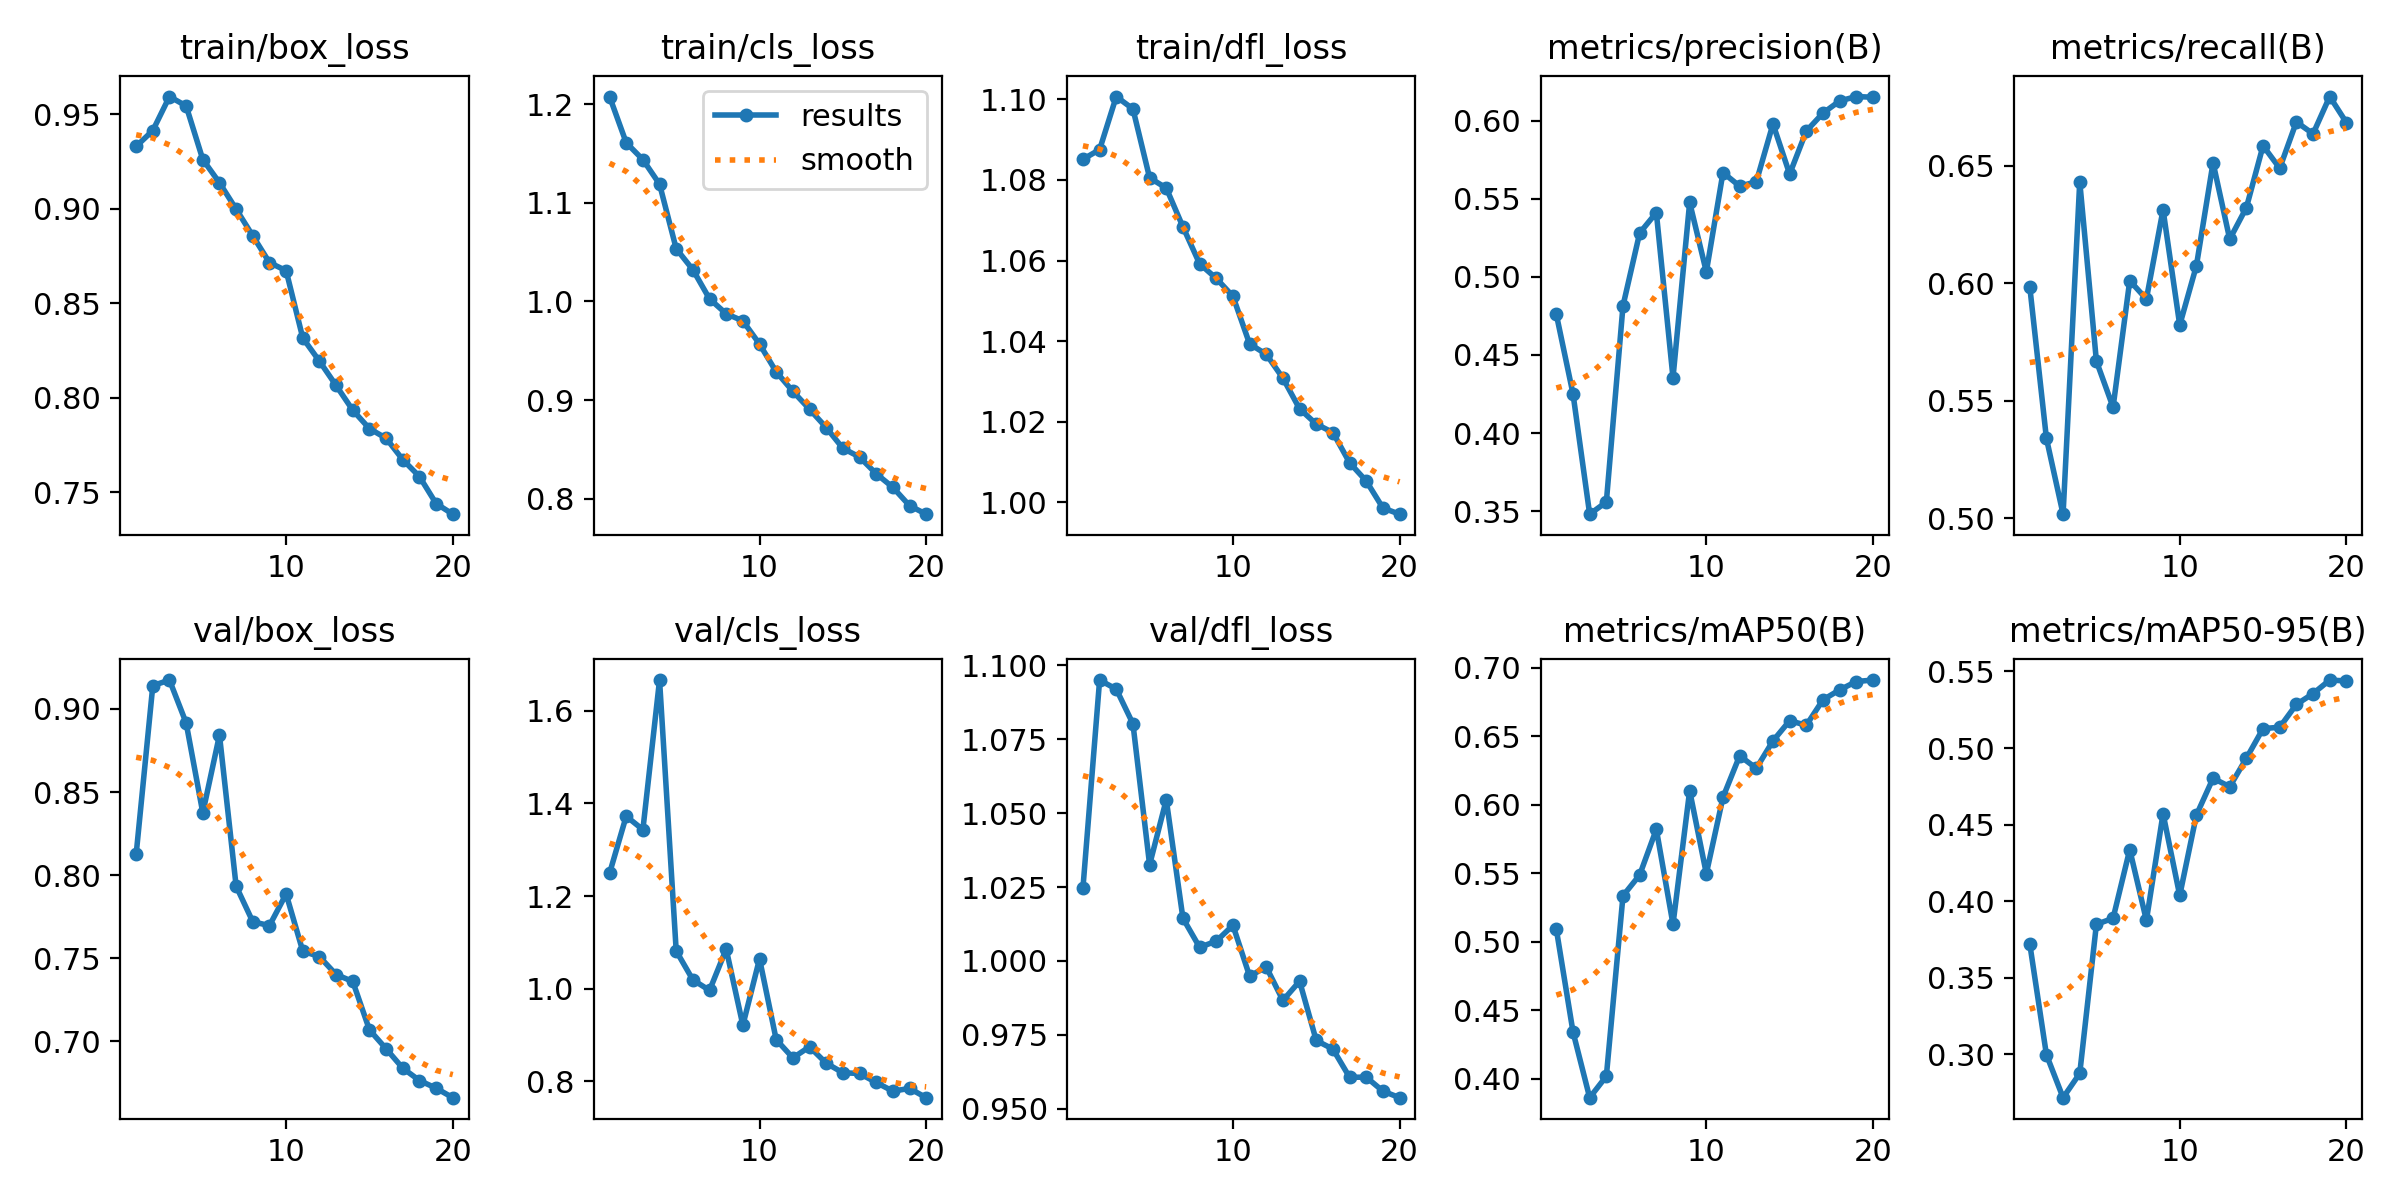

In [17]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/results.png', width=600)

/content


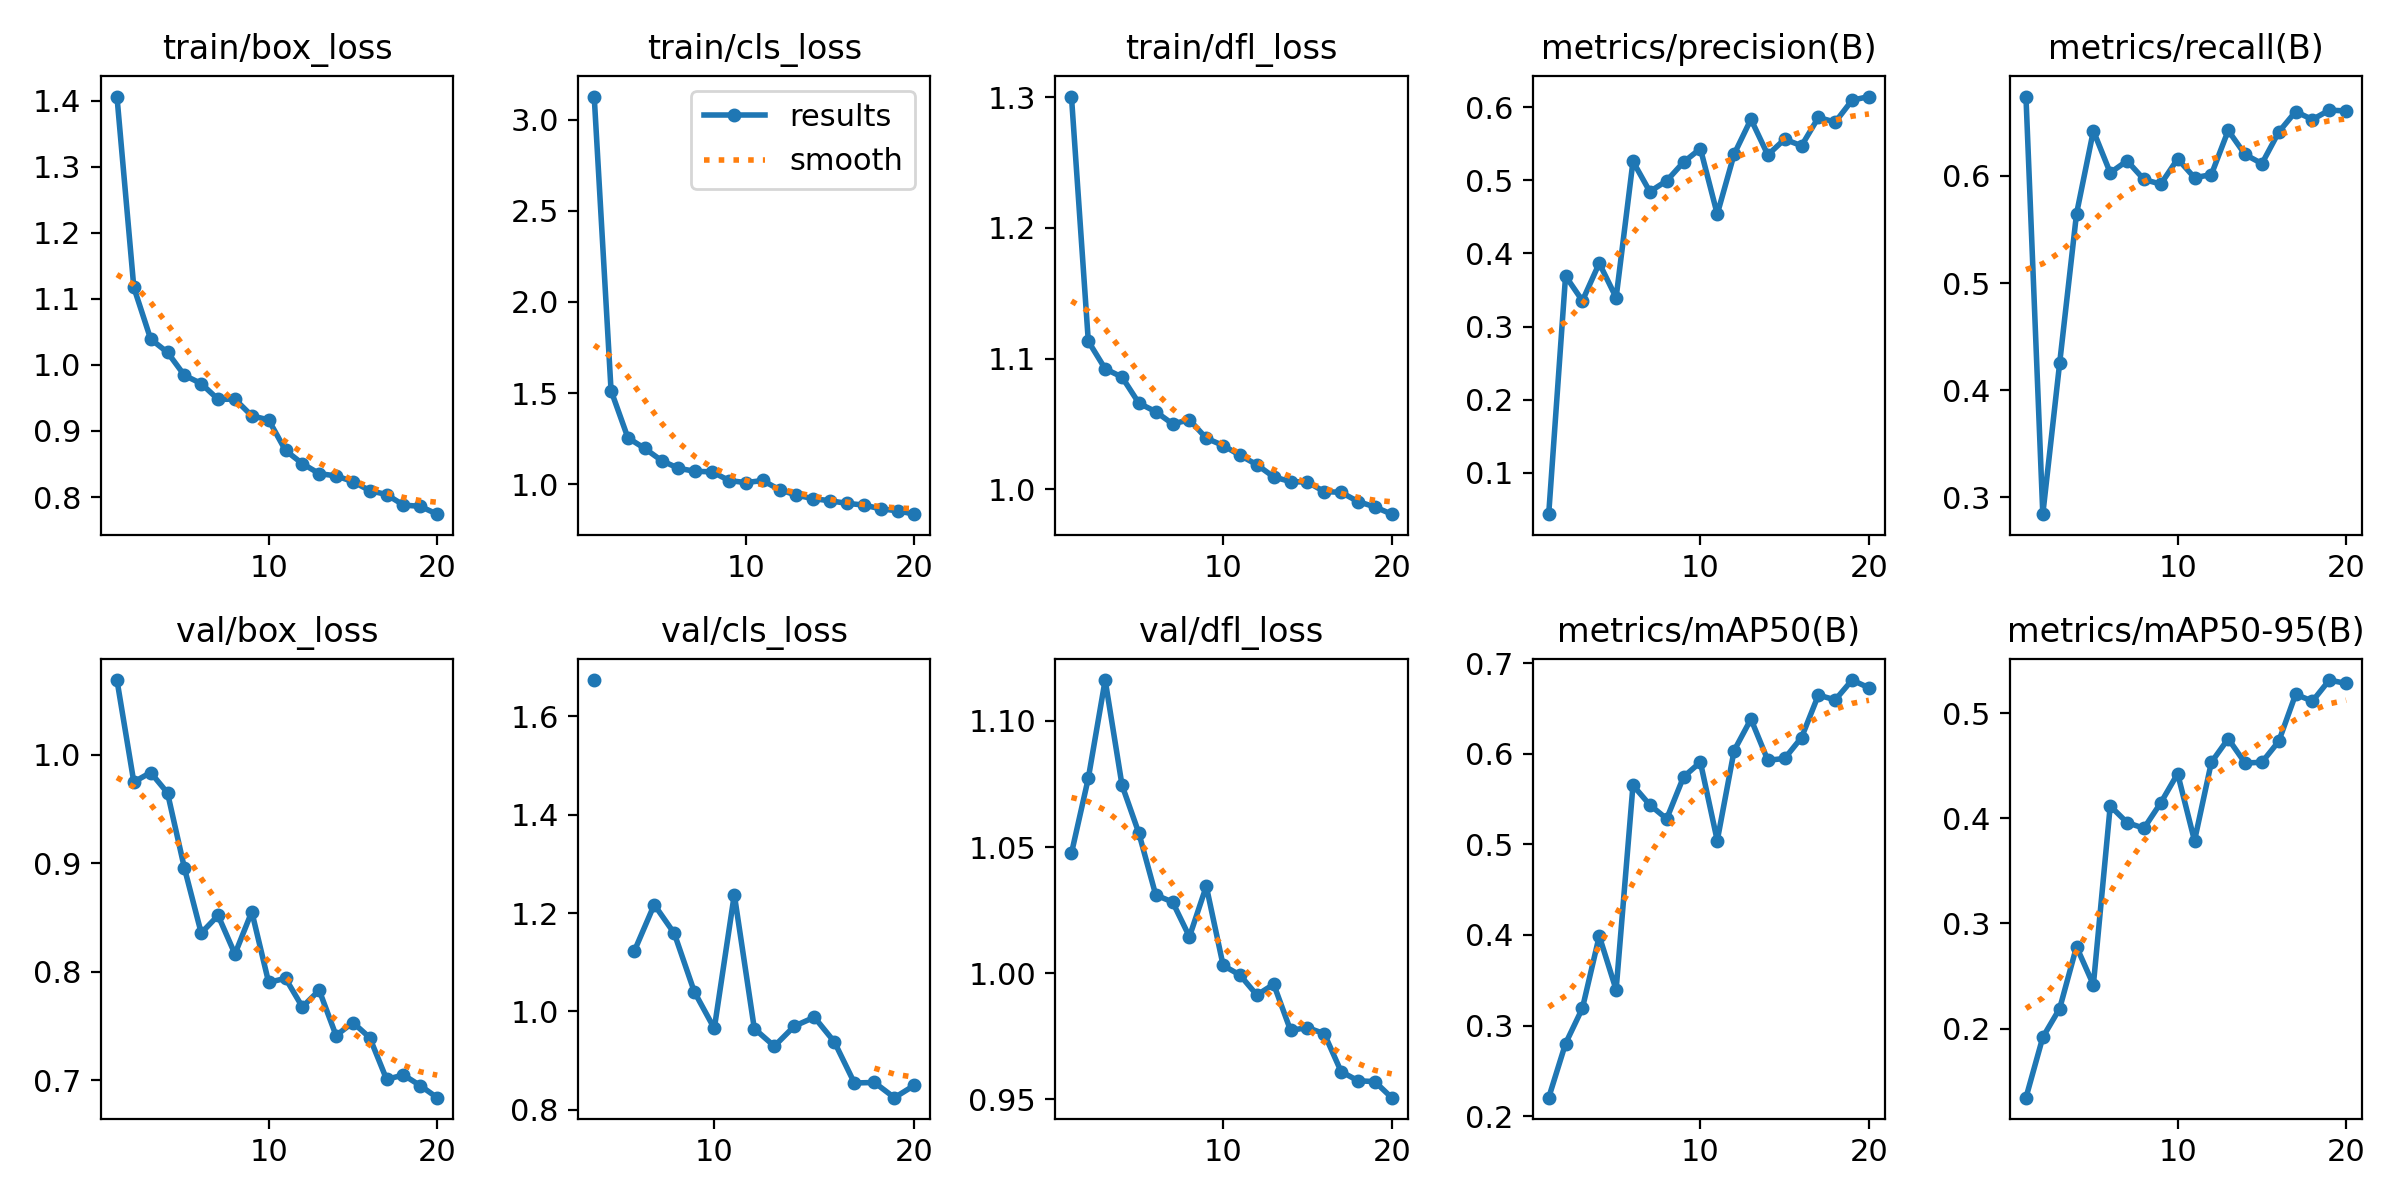

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/results.png', width=600)

/content


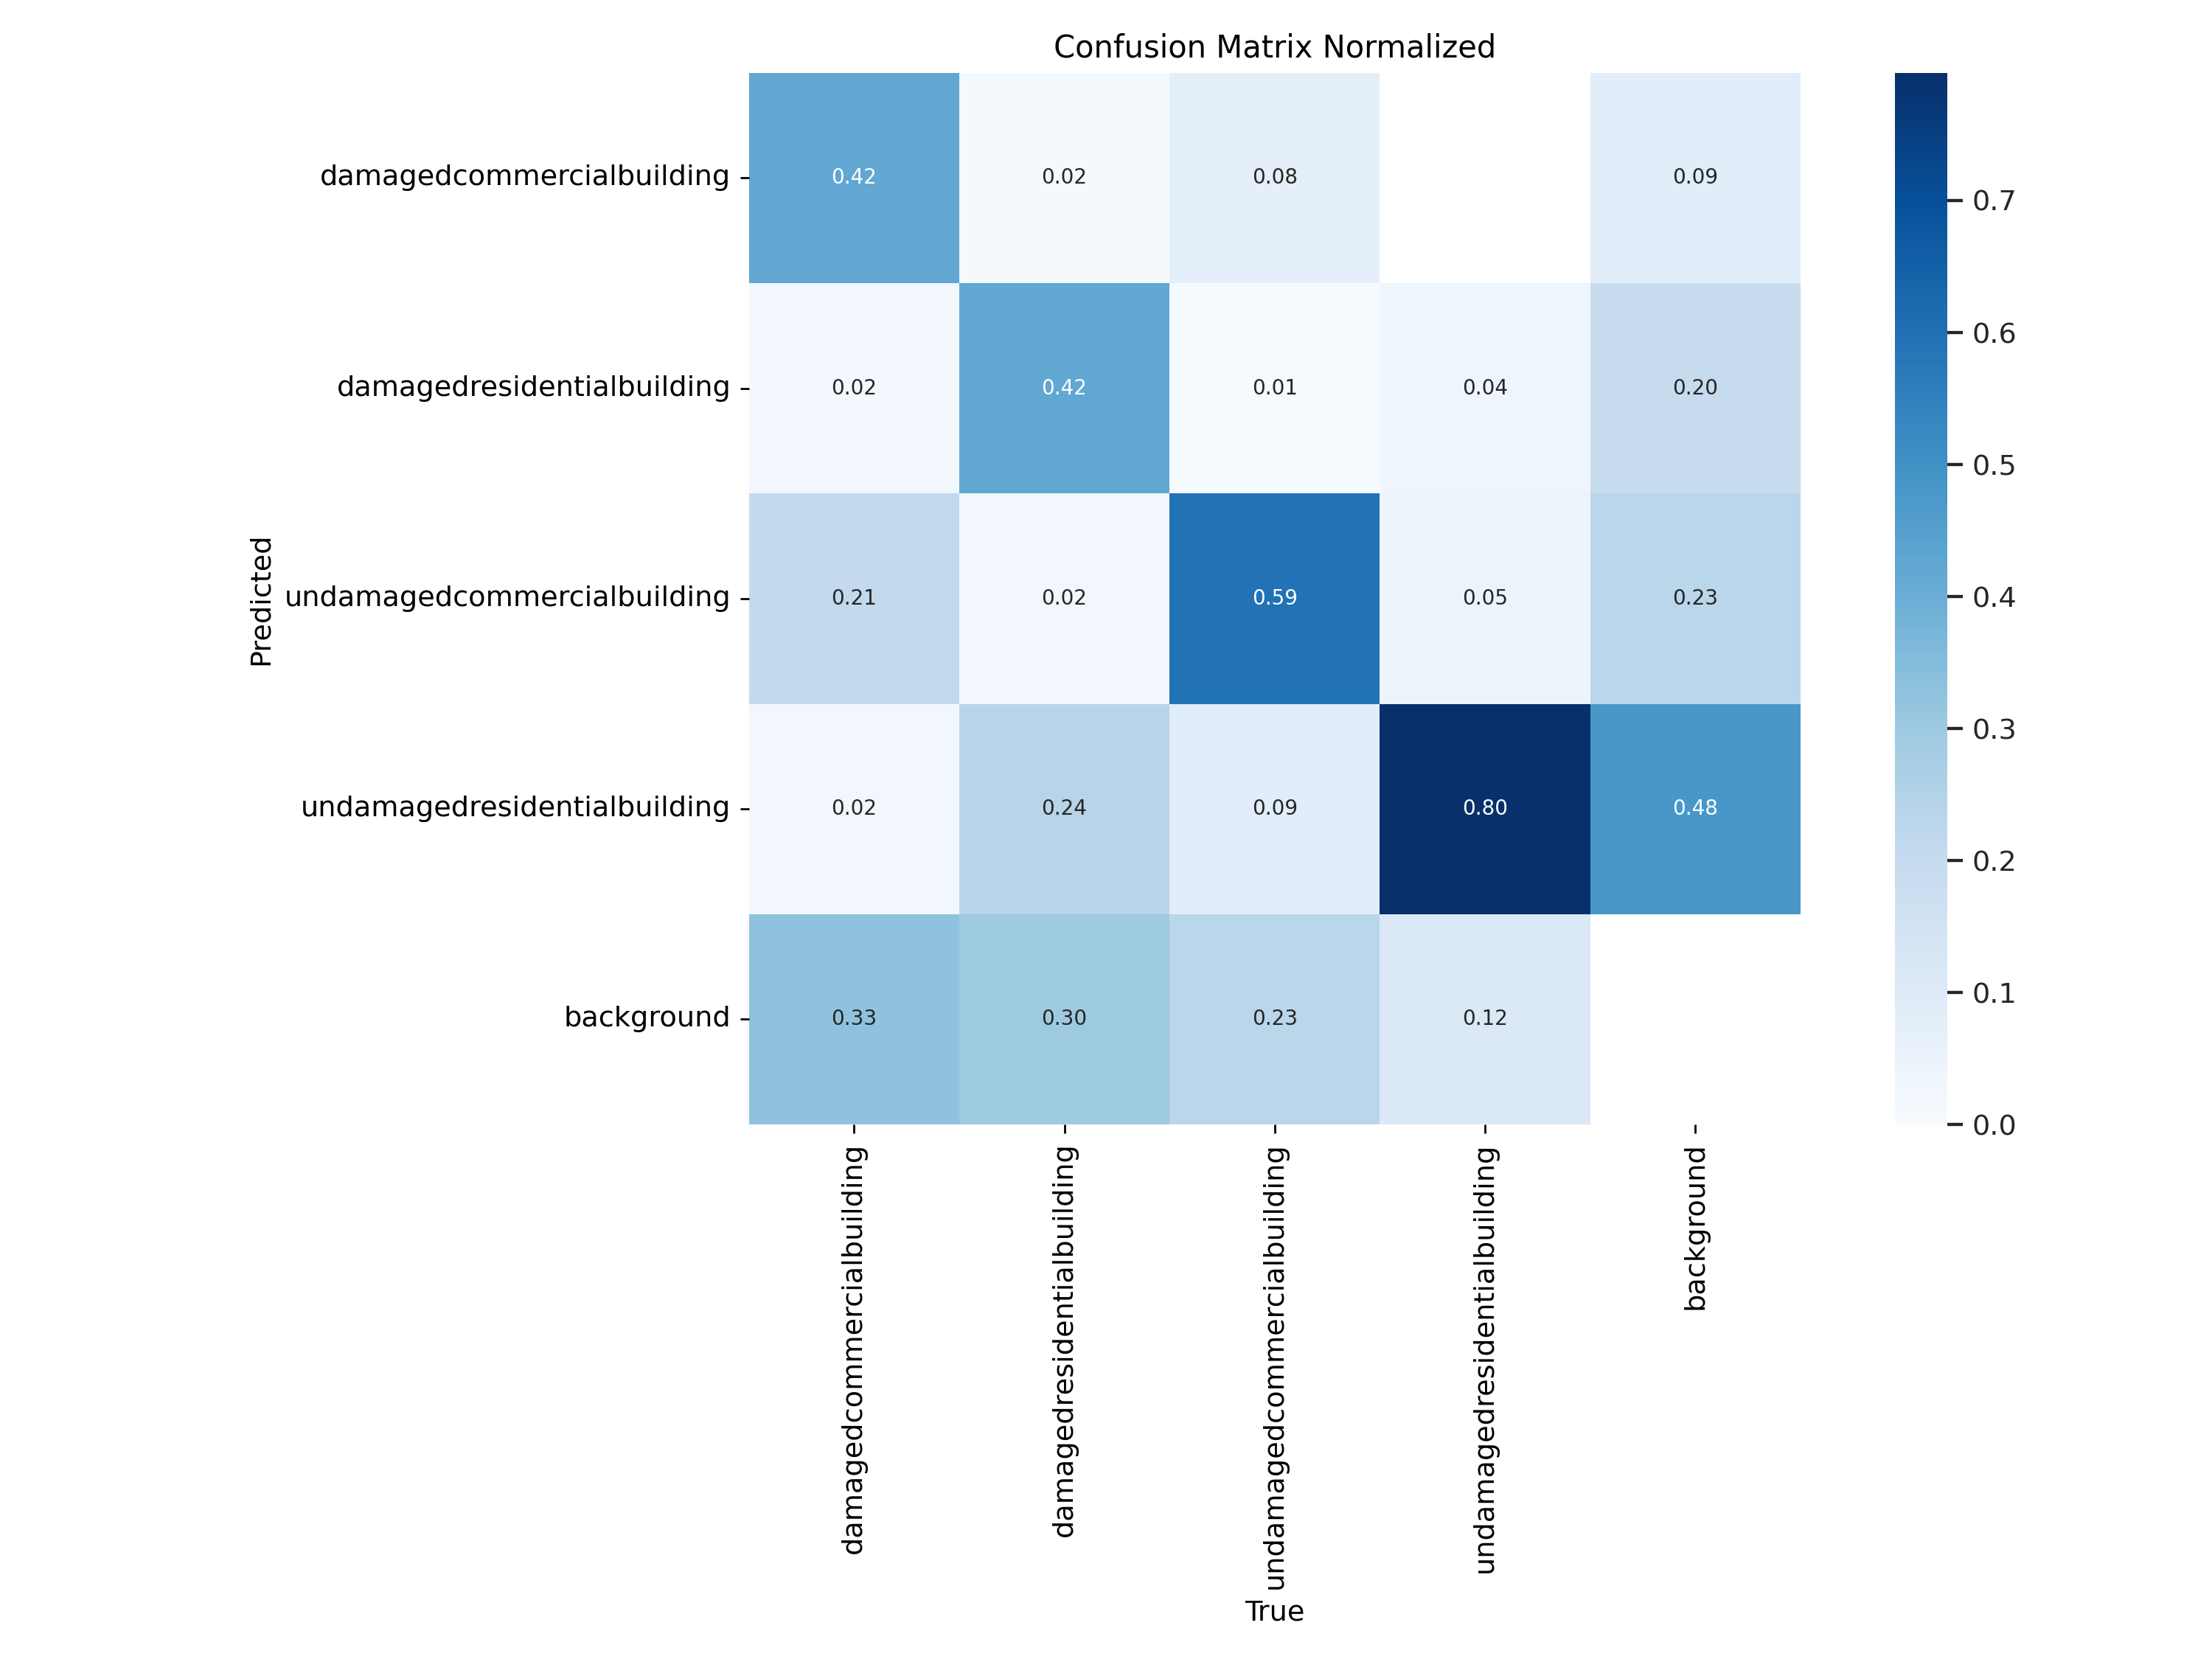

In [18]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/confusion_matrix_normalized.png', width=600)

/content


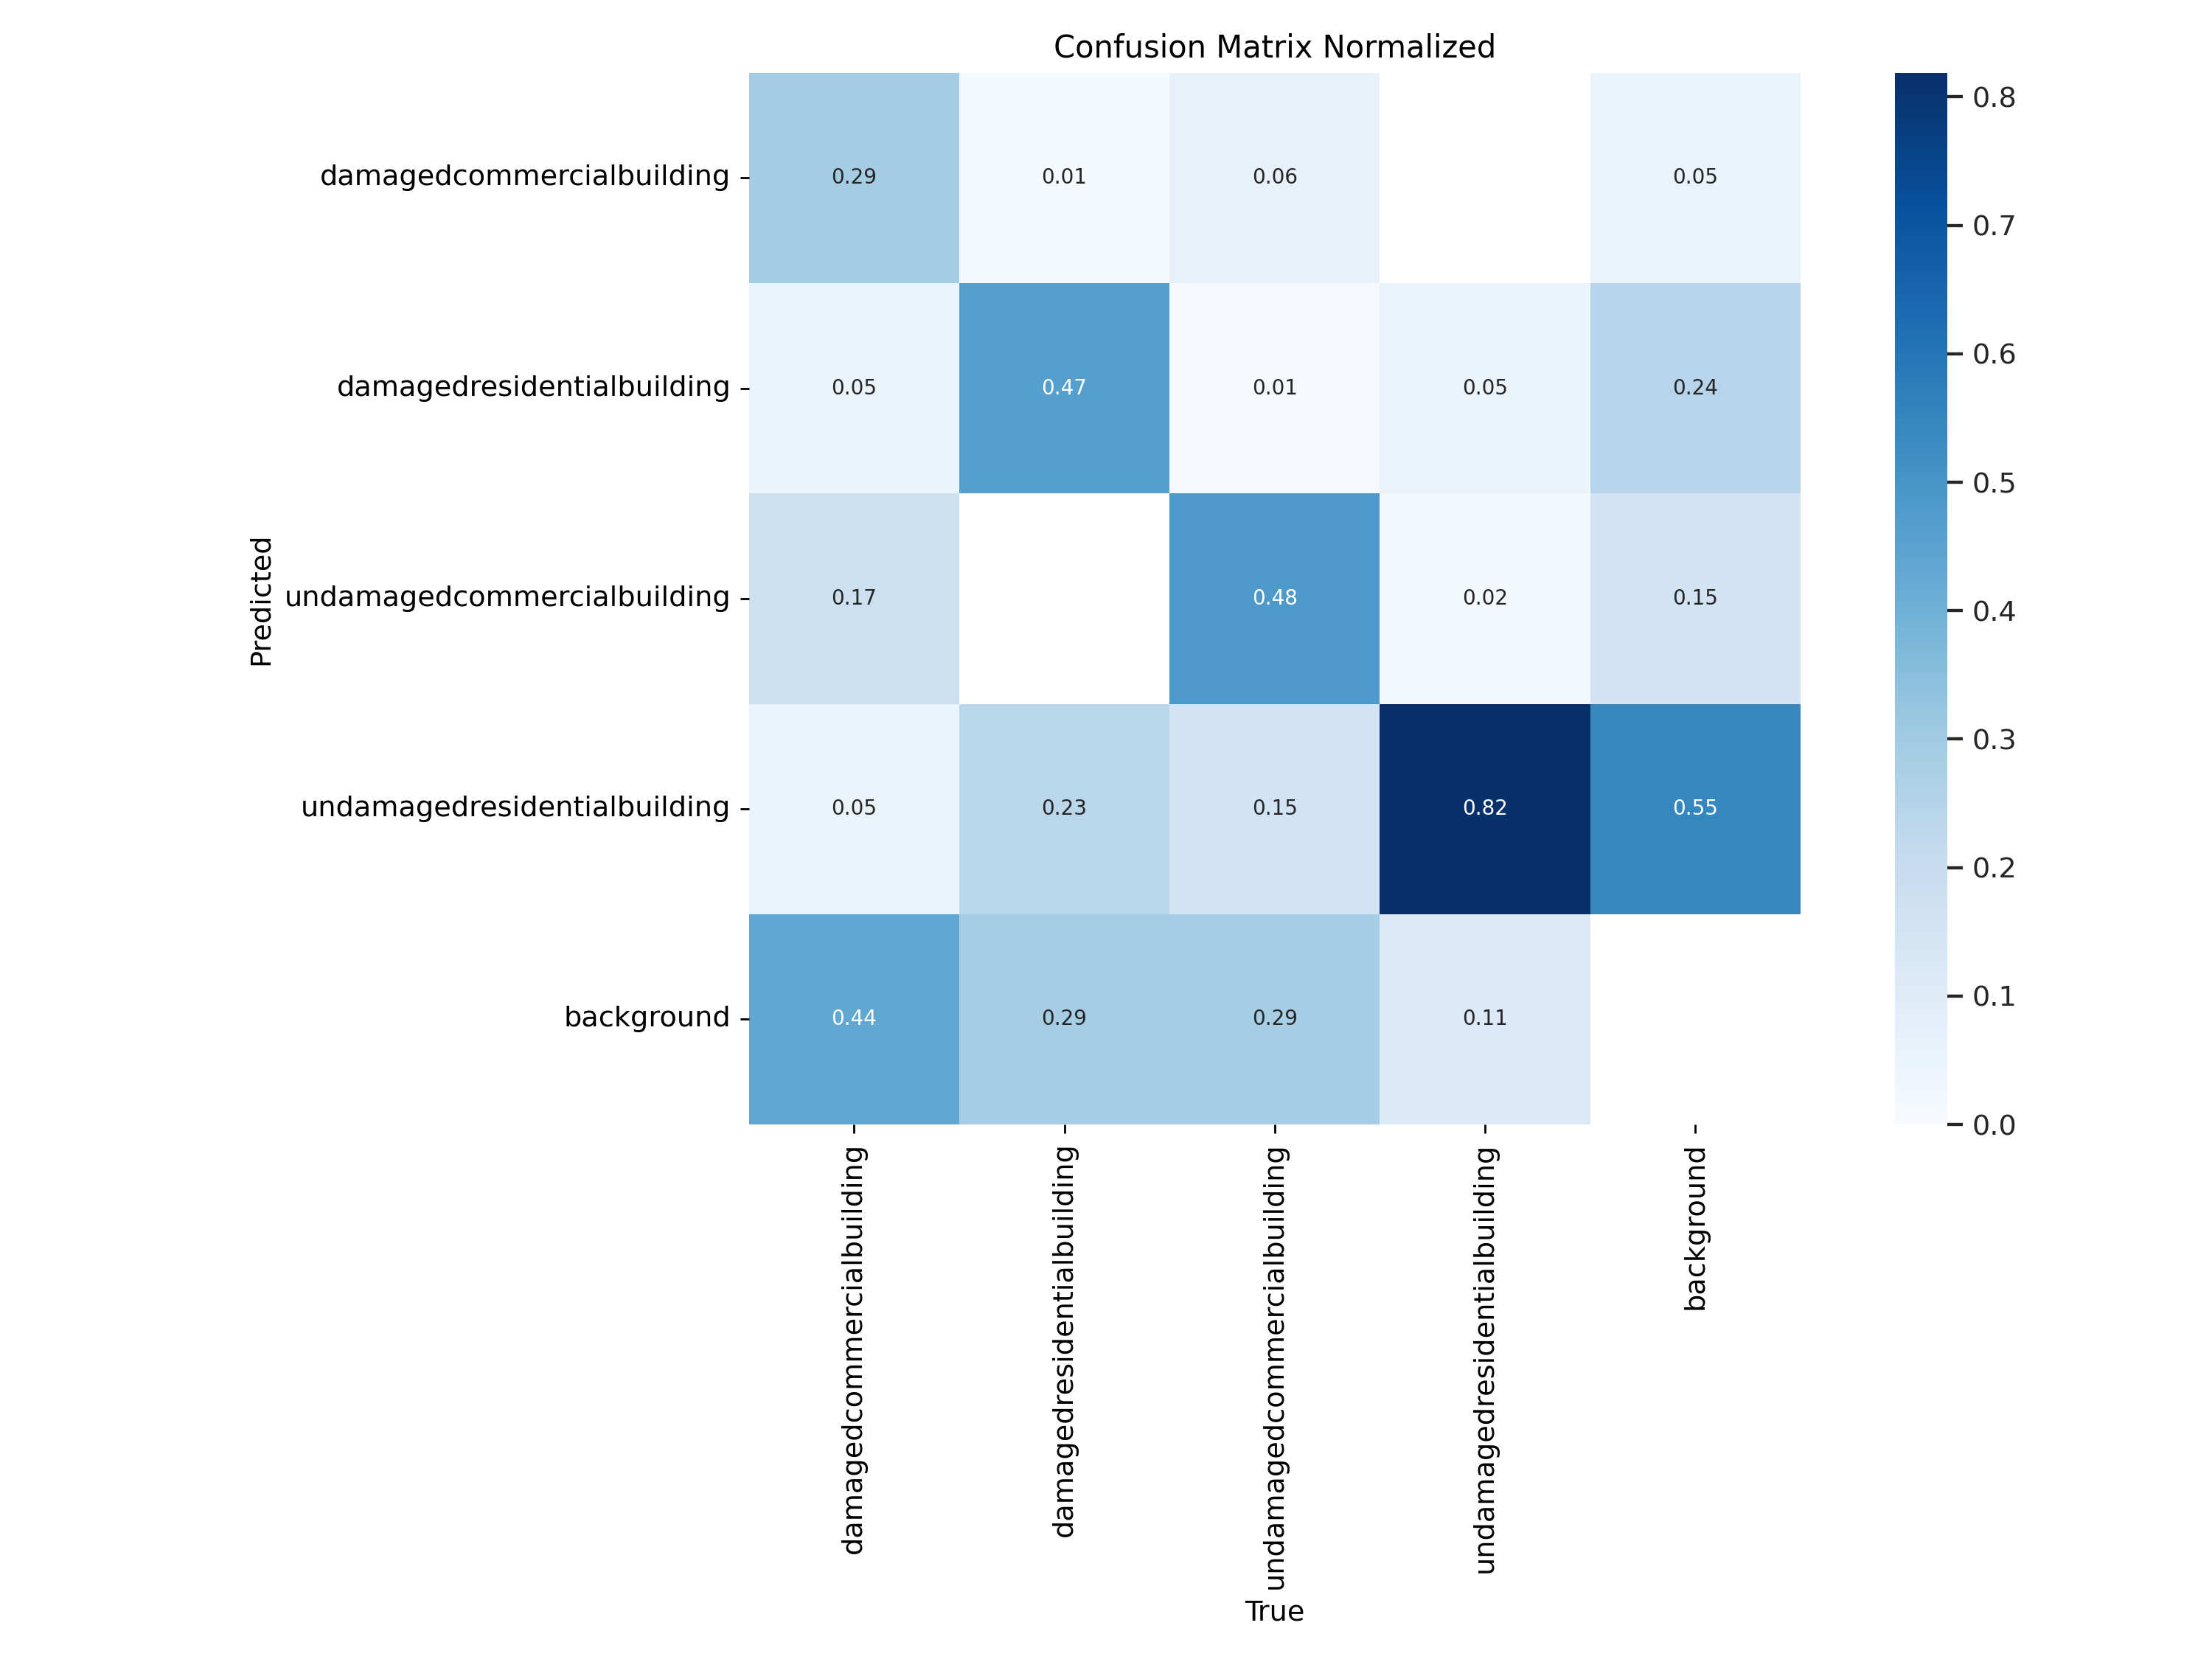

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/confusion_matrix_normalized.png', width=600)

## Testing the model performance on Test dataset

Ultralytics YOLOv8 doesn't have a separate mode=test option built-in, as it focuses on training and validation (i.e., mode=train and mode=val).

That being said, if you wish to evaluate your model on a test dataset, you can indeed do so by treating your test data as validation data. After finalizing your model from the validation stage, you can run your model on the test dataset using the mode='val'.

To do this, make sure your test dataset is in the appropriate format expected by YOLOv8. You can simply replace your /val split with your /test data when you're ready to perform testing. This way, you can use the validation mode to evaluate how your model performs on unseen data!

In [21]:
# Load the model from the best training weights (Note: select path of the "best.pt" file)
path_to_weights_best = f"/content/{project}/yolo11n_training_dataset_v4/weights/best.pt"
# /content/exploratory_phase/yolo11n_training_dataset_v4/weights/best.pt
model = YOLO(path_to_weights_best)

In [23]:
# Evaluate model metrics on the "test" dataset split
split_test = 'test'
name_metrics_test = f'metrics_{split_test}' # Directory name for saving results
metrics_test = model.val(data=yaml_file, imgsz=imgsz, batch=16, conf=0.25, iou=0.6, device=device, split=split_test, project=project, name=name_metrics_test)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/hurricanedamagev7-4/test/labels... 584 images, 0 backgrounds, 0 corrupt: 100%|██████████| 584/584 [00:01<00:00, 440.56it/s]


val: New cache created: /content/hurricanedamagev7-4/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:17<00:00,  2.08it/s]


                   all        584      11324      0.652      0.699      0.707      0.577
damagedcommercialbuilding        205        407      0.499      0.582      0.538      0.408
damagedresidentialbuilding        434       1871      0.684      0.565      0.652      0.523
undamagedcommercialbuilding        320       1214      0.572      0.764      0.719        0.6
undamagedresidentialbuilding        442       7832      0.851      0.884      0.918      0.776
Speed: 0.4ms preprocess, 5.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to exploratory_phase/metrics_test


In [24]:
# Load the model from the best training weights
split_val = 'val'
name_metrics_val = f'metrics_{split_val}' # Directory name for saving results
# Run the selected model
metrics_val = model.val(data=yaml_file, imgsz=imgsz, batch=16, conf=0.25, iou=0.6, device=device, split=split_val, project=project, name=name_metrics_val)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/hurricanedamagev7-4/valid/labels.cache... 597 images, 1 backgrounds, 0 corrupt: 100%|██████████| 597/597 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:19<00:00,  1.93it/s]


                   all        597      10864      0.605      0.704      0.671      0.546
damagedcommercialbuilding        242        468      0.452      0.574      0.485      0.357
damagedresidentialbuilding        434       1787      0.636      0.593      0.625      0.502
undamagedcommercialbuilding        344       1264      0.498      0.763      0.661      0.553
undamagedresidentialbuilding        455       7345      0.833      0.888      0.912      0.772
Speed: 0.5ms preprocess, 5.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to exploratory_phase/metrics_val


In [ ]:
# metrics_test.box.method

AttributeError: 'Metric' object has no attribute 'keys'. See valid attributes below.

    Class for computing evaluation metrics for YOLOv8 model.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50(): AP at IoU threshold of 0.5 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        ap(): AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        mp(): Mean precision of all classes. Returns: Float.
        mr(): Mean recall of all classes. Returns: Float.
        map50(): Mean AP at IoU threshold of 0.5 for all classes. Returns: Float.
        map75(): Mean AP at IoU threshold of 0.75 for all classes. Returns: Float.
        map(): Mean AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: Float.
        mean_results(): Mean of results, returns mp, mr, map50, map.
        class_result(i): Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps(): mAP of each class. Returns: Array of mAP scores, shape: (nc,).
        fitness(): Model fitness as a weighted combination of metrics. Returns: Float.
        update(results): Update metric attributes with new evaluation results.
    

In [25]:
print(f"The model \'{model_version}{model_variant}\' trained on dataset \'{dataset_name}-version{dataset_version}\'")
print(f"Below, comparison of evaluation metrics on dataset splits \'{split_test}\' and \'{split_val}\'")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - mAP of each class: {metrics_test.box.maps}")
print(f"Val dataset - mAP of each class: {metrics_val.box.maps}")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: {metrics_test.box.map}")
print(f"Val dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: {metrics_val.box.map}")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - Mean AP at IoU threshold of 0.5 for all classes: {metrics_test.box.map50}")
print(f"Val dataset - Mean AP at IoU threshold of 0.5 for all classes: {metrics_val.box.map50}")

The model '11n' trained on dataset 'hurricanedamagev7-version4'
Below, comparison of evaluation metrics on dataset splits 'test' and 'val'
--------------------------------------------------------------------------------
Test dataset - mAP of each class: [    0.40829     0.52302     0.59954     0.77613]
Val dataset - mAP of each class: [    0.35667     0.50163     0.55263      0.7718]
--------------------------------------------------------------------------------
Test dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: 0.576744796006978
Val dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: 0.5456836777356007
--------------------------------------------------------------------------------
Test dataset - Mean AP at IoU threshold of 0.5 for all classes: 0.706850268902439
Val dataset - Mean AP at IoU threshold of 0.5 for all classes: 0.6709426798763246


## Downloading Results (.zip file)

In [26]:
from google.colab import files

# Define download parameters and file names
path_dir_to_zip = '/content/exploratory_phase/yolo11n_training_dataset_v4' #@param {type: "string"}
output_filename = 'yolo11n_training_dataset_v4.zip' #@param {type: "string"}
path_zip_file = f'{HOME}/{output_filename}'
delete_zip_file_after_download = "No"  #@param ['Yes', 'No']

os.system("zip -r {} {}".format(output_filename, path_dir_to_zip))
# Download file to local machine
files.download(output_filename)
# Delete the created zip file (optional)
if delete_zip_file_after_download == "Yes":
    os.system("rm -r {}".format(path_zip_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Draft Code (not important)

## Loading Training Datasets

Mound google drive which contains the required training dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Check internet speed (optional)

In [ ]:
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.126.168.143)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by PT. Jala Lintas Media (Semarang) [1171.81 km]: 30.175 ms
Testing download speed................................................................................
Download: 263.09 Mbit/s
Testing upload speed......................................................................................................
Upload: 184.19 Mbit/s


Print the current working directory in google collab

In [ ]:
!pwd

/content


Create a new directory for the dataset

In [ ]:
!mkdir data

In [ ]:
!cp -r ../gdrive/MyDrive/Colab\ Notebooks/datasets/hurricanedamagev7.v2i.yolov8.train.valid /content/data

Copy the whole directory with results to a connected google drive

In [ ]:
!scp -r /content/runs /content/gdrive/My Drive/ComputerVision/TrainingResults # adapt to own folder name